# Run MCMC sampling
# Light minimal NO geometry, fitting log(m_4), log(m_z)

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import numpy as np

from Likelihood import LEff
from mcmc_utils import light_minimal_mcmc

from multiprocessing import Pool
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [25]:
hierarchy = 'light'
D_or_M = 'majorana'
distance = 'log'
smoothing_pars = (0.1, 0.1)

selection = 'cut_based'
set_backend = True
reset_backend = False
n_samples = 2000

spec = 'minimal no geometry and logs'

In [6]:
this_dark_nus_mcmc = light_minimal_mcmc(hierarchy, D_or_M, title_addition=spec,
                                   distance=distance, smoothing_pars=smoothing_pars)
df = this_dark_nus_mcmc.provide_df(selection)

light majorana


In [8]:
ndim = 4
from ctau_utils import ctau_light
from const import alphaQED
def light_minimal_posterior_no_geometry_log_masses(parameters):
    '''Posterior in the light minimal model with no geometry: parameters = [log10_m4, log10_mz, log10_Vmu4, log10_epsilon]
       It uses global pars to speed up parallel computation'''
    if (parameters[0] < np.log10(this_dark_nus_mcmc.exp_analysis_obj.m4_limits[0])) or\
       (parameters[0] > np.log10(this_dark_nus_mcmc.exp_analysis_obj.m4_limits[1])) or\
       (parameters[1] < np.log10(this_dark_nus_mcmc.exp_analysis_obj.mz_limits[0])) or\
       (parameters[1] > np.log10(this_dark_nus_mcmc.exp_analysis_obj.mz_limits[1])) or\
       (parameters[0] <= parameters[1]) or\
       (parameters[2] <= np.log10(this_dark_nus_mcmc.exp_analysis_obj.lower_bound_Vmu4)) or\
       (parameters[2] > np.log10(this_dark_nus_mcmc.exp_analysis_obj.upper_bound_Vmu4)) or\
       (parameters[3] <= np.log10(this_dark_nus_mcmc.exp_analysis_obj.lower_bound_epsilon)) or\
       (parameters[3] > np.log10(this_dark_nus_mcmc.exp_analysis_obj.upper_bound_epsilon)):
        return -np.inf, -np.inf, -np.inf, -np.inf
    else:
        actual_m4 = 10**parameters[0]
        actual_mz = 10**parameters[1]
        actual_Vmu4 = 10**parameters[2]
        actual_Vmu4_alpha_epsilon2 = actual_Vmu4 * alphaQED * 10**(2*parameters[3])
        ctau = ctau_light(actual_m4, 
                          actual_mz, 
                          actual_Vmu4, 
                          D_or_M)
        this_mu = actual_Vmu4_alpha_epsilon2/this_dark_nus_mcmc.exp_analysis_obj.Vmu4_alpha_epsilon2
        mu, sigma2 = this_dark_nus_mcmc.exp_analysis_obj.kde_n_events(df=df,
                                                         m4mz=(actual_m4, actual_mz),
                                                         ctau=None,
                                                         mu=this_mu,
                                                         distance=this_dark_nus_mcmc.distance,
                                                         smoothing=this_dark_nus_mcmc.smoothing_pars)
        return LEff(0, mu, sigma2), mu, sigma2, ctau

labels = ['log10_m4', 'log10_mz', 'log10_Vmu4', 'log10_epsilon']
blobs_dtype = [('mu', float), ('sigma2', float), ('ctau', float)]

In [10]:
this_dark_nus_mcmc.set_posterior(light_minimal_posterior_no_geometry_log_masses, 
                                 ndim, 
                                 labels=labels)

In [27]:
n_walkers = ndim**2
with Pool() as pool:
    this_dark_nus_mcmc.initialise_mcmc(n_walkers, pool,
                                       set_backend=set_backend, reset_backend=reset_backend, 
                                       blobs_dtype=blobs_dtype, log_ms=True)
    this_dark_nus_mcmc.run_mcmc(n_samples)

100%|██████████| 2000/2000 [55:45<00:00,  1.67s/it] 


/n/home00/nfoppiani/.conda/envs/dark_nus/lib/python3.8/site-packages/emcee/autocorr.py:36: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
N/50 = 0;
tau: [1.73435193 1.19500428 1.61114892 1.33918251]
N/50 = 0;
tau: [2.64789311 2.28830487 2.56105474 2.60705415]
N/50 = 1;
tau: [4.43686691 4.49550634 4.79585625 4.23226341]
N/50 = 2;
tau: [7.92689693 7.67829353 7.78709986 7.31094272]
N/50 = 3;
tau: [13.91173956 14.04601494 11.80064485 13.14404989]
N/50 = 5;
tau: [22.88044157 22.46034353 21.75756415 24.92429473]
N/50 = 8;
tau: [34.49598594 35.34362845 32.07876876 34.7758766 ]
N/50 = 14;
tau: [53.96920661 61.16004302 48.92630391 48.23192773]
N/50 = 23;
tau: [74.16768862 85.22452538 76.94098326 68.27750012]
N/50 = 40;
tau: [108.30754206  90.77097011  99.32540657  80.61989319]


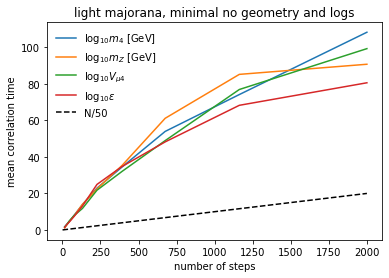

In [26]:
this_dark_nus_mcmc.compute_autocorrelation_time(store=True)

In [18]:
this_dark_nus_mcmc.get_samples(discard=0, thin=1)

N/50 = 2;
tau: [11.28447151 10.14844224  9.66506606  9.62711963]


(<Figure size 1080x504 with 5 Axes>,
 array([<AxesSubplot:ylabel='$\\log_{10}m_4$ [GeV]'>,
        <AxesSubplot:ylabel='$\\log_{10}m_Z$ [GeV]'>,
        <AxesSubplot:ylabel='$\\log_{10}V_{\\mu 4}$'>,
        <AxesSubplot:ylabel='$\\log_{10}\\epsilon$'>,
        <AxesSubplot:xlabel='step number', ylabel='log(p)'>], dtype=object))

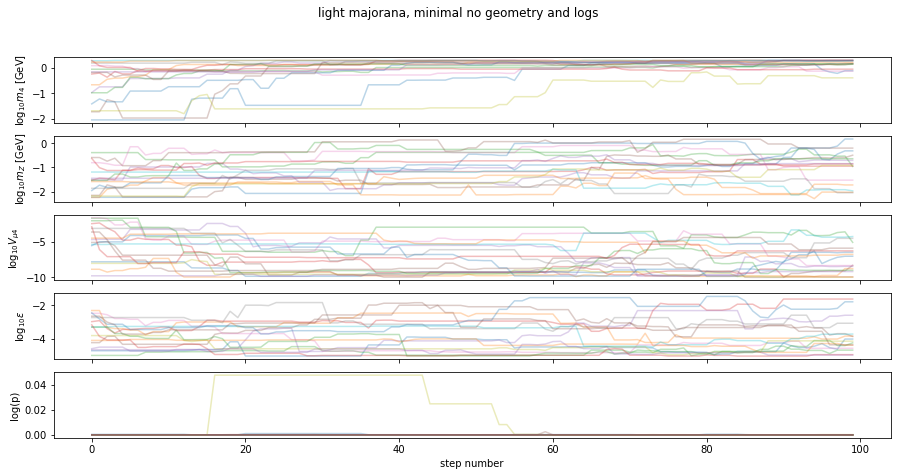

In [19]:
this_dark_nus_mcmc.plot_chains(store=True)

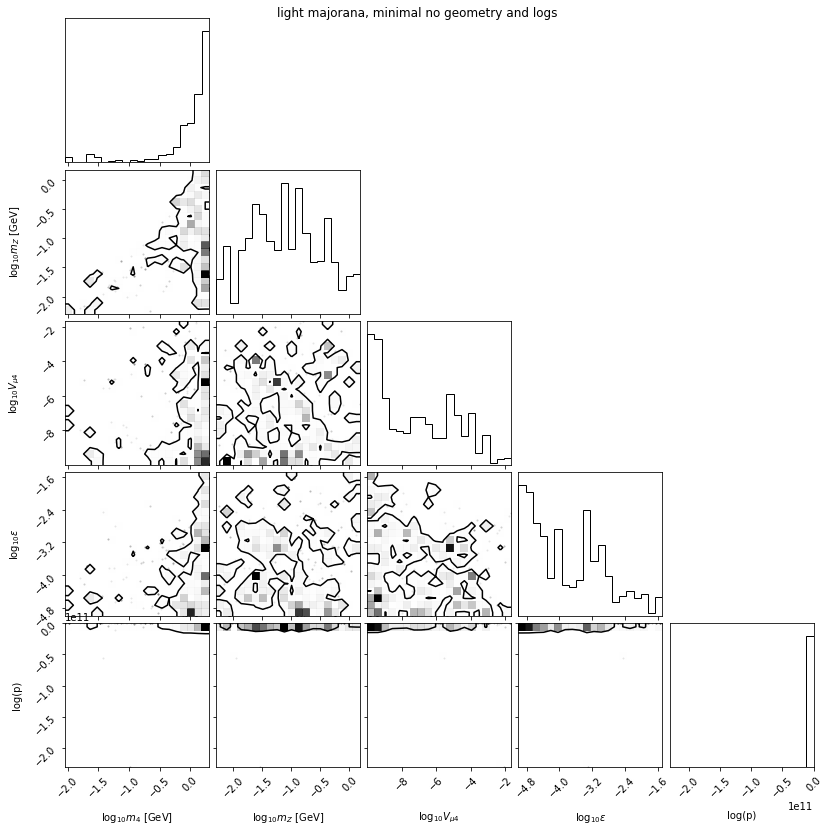

In [20]:
this_dark_nus_mcmc.corner_plot_raw(savefile='raw_corner')

In [ ]:
this_dark_nus_mcmc.corner_plot_physics(savefile='physics_corner')

In [21]:
print('Fraction of samples with null expectation =', (this_dark_nus_mcmc.samples['mu'] == 0).sum()/len(this_dark_nus_mcmc.samples))

Fraction of samples with null expectation = 0.07625


In [ ]:
this_dark_nus_mcmc.corner_plot_with_colour('log10_mu', savefile='corner_log10_mu')

In [ ]:
this_dark_nus_mcmc.corner_plot_with_colour('log10_sigma/mu', savefile='corner_log10_sigma_mu')

In [ ]:
this_dark_nus_mcmc.corner_plot_with_colour('log10_ctau', savefile='corner_log10_ctau')